SARIMAX MODEL: Adding external Variables to our Model

In [1]:
import statsmodels.api as sm 

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Our target variable(endogenous variable) is the realgdp. We will only work with 6 variables for simplicity

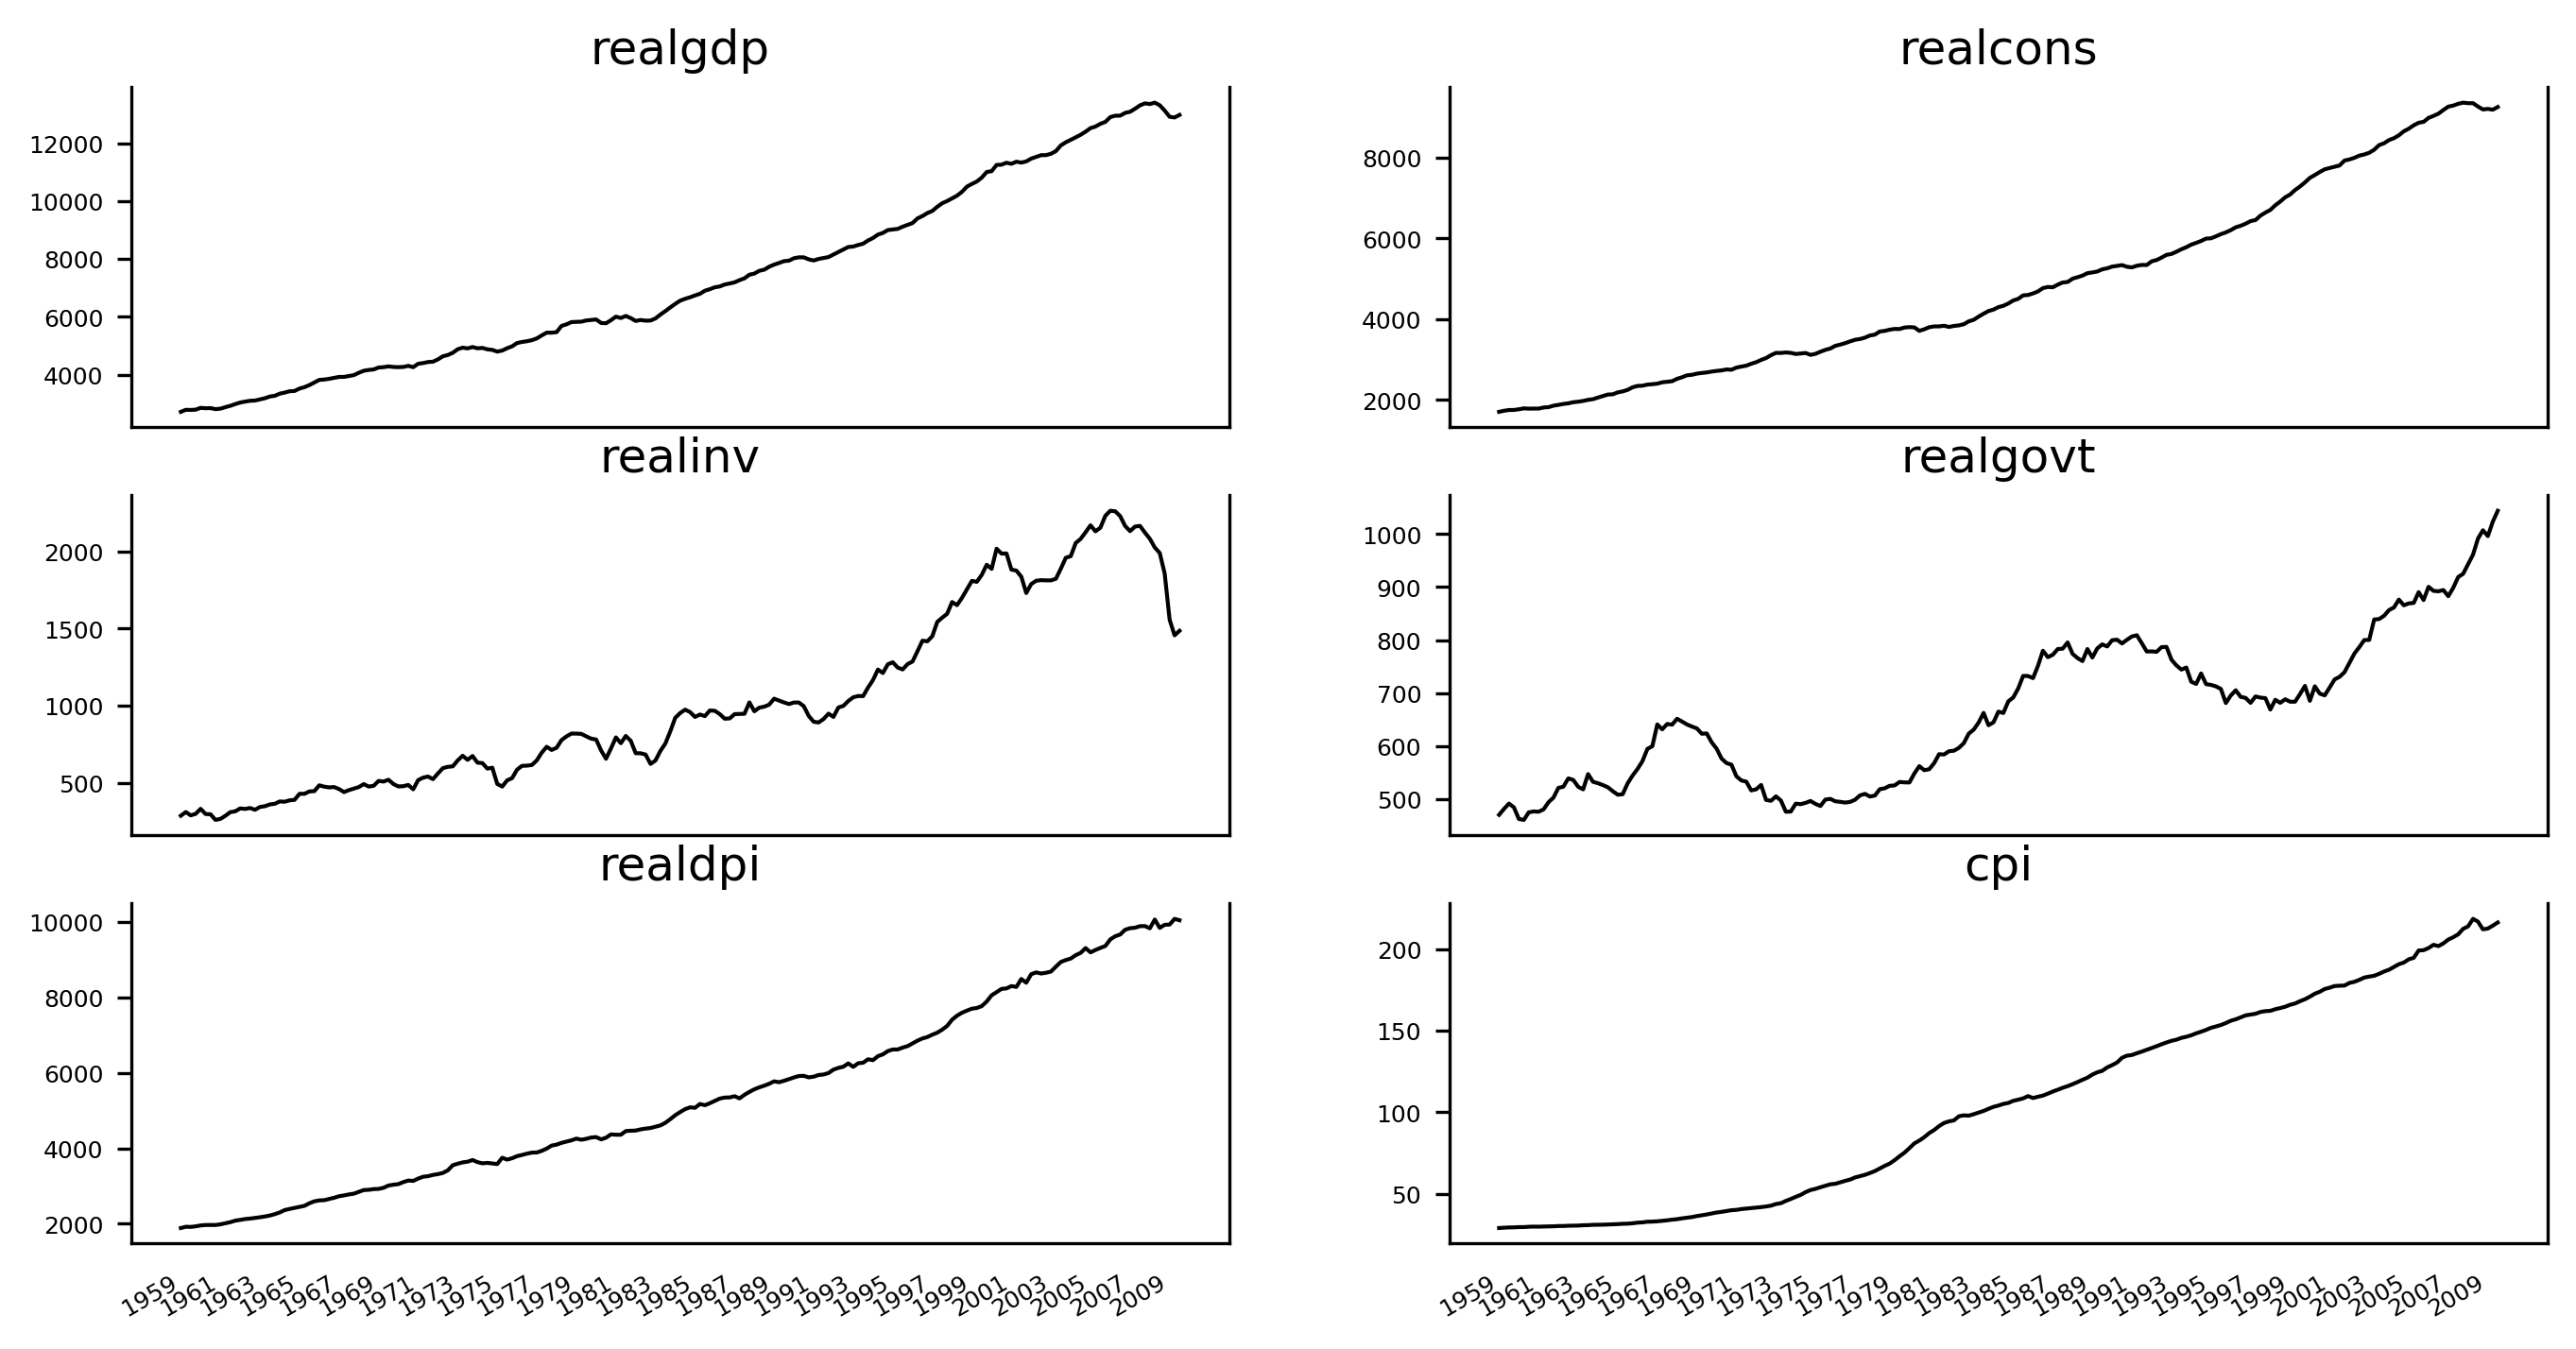

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize = (11,6))

for i, ax in enumerate(axes.flatten()[:6]):  #iterate for 6 variables
    data = macro_econ_data[macro_econ_data.columns[i+2]] #skip the year and quarter columns

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2]) #varibles name at the top of the plot
    ax.xaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes,xticks=np.arange(0,208,8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.show()

Forecasting the real GDP using sarimax model

In [5]:
#test for stationarity using ADF test
from statsmodels.tsa.stattools import adfuller

target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons','realinv','realgovt','realdpi','cpi']] #limited to 5 variables

ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647104
p-value: 0.9982455372335032


In [7]:
#series is not stationary thus apply transformation and test again
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statstic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statstic: -6.305695561658104
p-value: 3.327882187668259e-08


ADF statistic of –6.31 and p-value of 3.32 × 10–8. With a large negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis and conclude that the series is now stationary. 

We know that d = 1. Since we did not need to take a seasonal difference to make the series stationary, D = 0.

Let's write a function to fit all the unique combinations of the model

In [8]:
from typing import Union
from tqdm import tqdm_notebook

from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list:list, d:int, D:int, s:int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model= SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order= (order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [11]:
from itertools import product

p = range(0,4,1)
d=1
q= range(0,4,1)
P= range(0,4,1)
D = 0
Q= range(0,4,1)
s=4  #since the data is collected quarterly m=4 

parameters = product(p,q,P,Q)
parameters_list = list(parameters) 

In [13]:
#for training set, we use the first 200 instances of both the target and exogenous variables
import warnings
warnings.filterwarnings('ignore') 

target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D,s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824524
1,"(3, 3, 1, 0)",1744.966356
2,"(3, 3, 0, 1)",1744.996638
3,"(2, 2, 0, 0)",1745.504197
4,"(2, 2, 0, 1)",1746.233348
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


SARIMAX(3,1,3)(0,0,0)4 is the model with the lowest AIC. The seasonal component has only orders of 0 so we have an ARIMAX(3,1,3) model

In [15]:
#fit the selected model

best_model_fit = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False).fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Tue, 30 Jul 2024   AIC                           1742.825
Time:                        12:51:45   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.496      0.000       0.882       1.059
realinv        1.0131      0.033     30.688      0.000       0.948       1.078
realgovt       0.7286      0.127      5.730      0.0

Notice that all exogenous variables have a p-value smaller than 0.05, except for realdpi, which has a p-value of 0.680. This means that the coefficient of realdpi is not significantly different from 0. You’ll also notice that its coefficient is
0.0103. However, the coefficient is kept in the model, as the p-value does not determine the relevance of this predictor in forecasting our target.

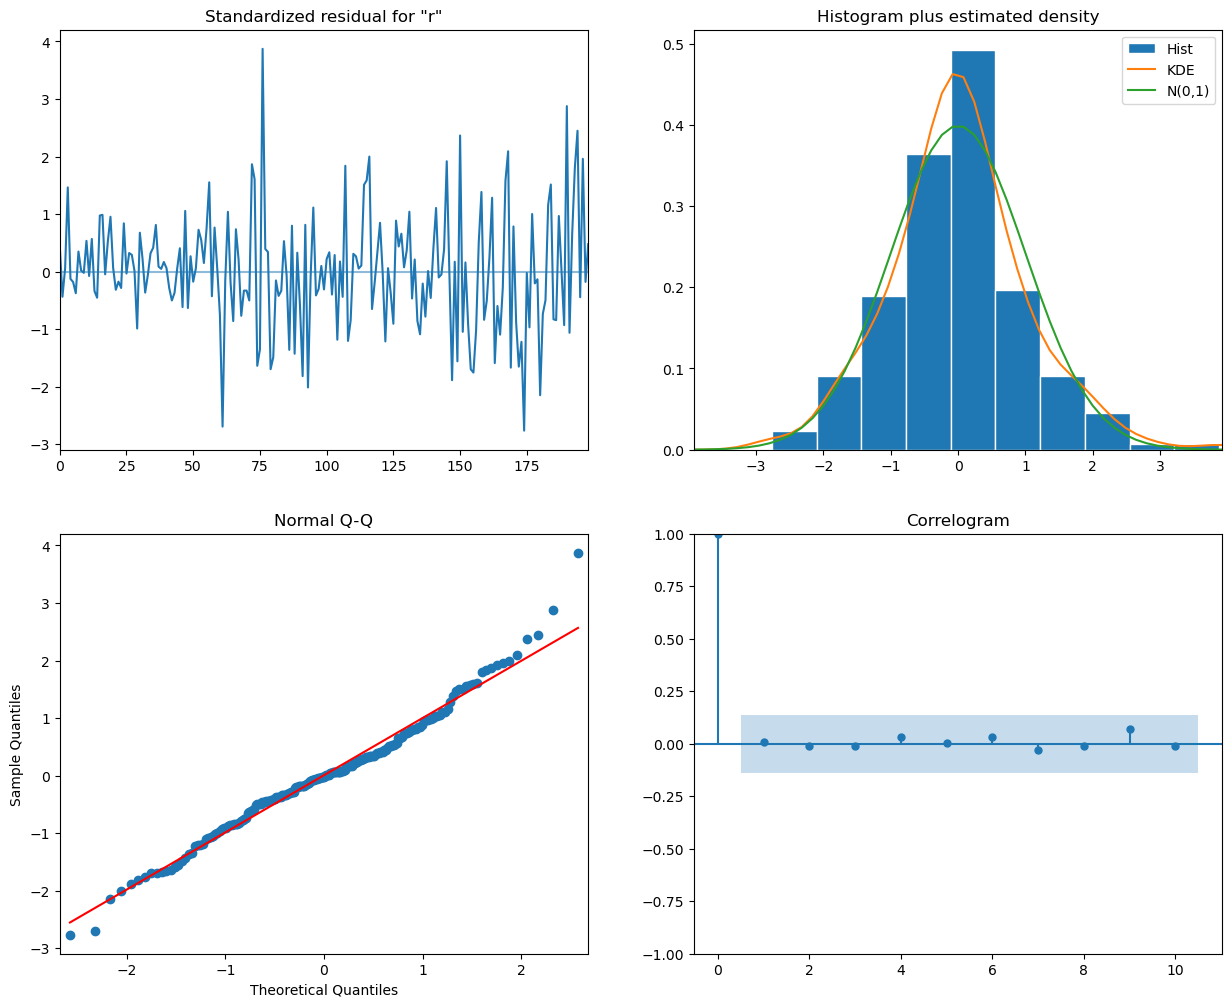

In [16]:
#study the residuals of the model to see if they are white noise

best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [18]:
#Apply the Ljung-Box test to ensure the residuals are not related 

from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = best_model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=10)

print(lb_test)

     lb_stat  lb_pvalue
1   0.091150   0.762720
2   0.197626   0.905912
3   0.199694   0.977639
4   1.258576   0.868363
5   1.259332   0.939060
6   1.286499   0.972397
7   1.477912   0.983064
8   1.487782   0.992909
9   1.861257   0.993476
10  1.868097   0.997255


We do not rejcet the null hypothesis since p-value is greater than 0.05. The residuals are not correlated. 

The caveat of using a SARIMAX model is that it is reasonable to predict only the next timestep, to avoid predicting the exogenous variables as well,which would lead us to accumulate prediction errors in the final forecast.

Instead, to test our model, we predict the next timestep multiple times and average the errors of each prediction. This is done using the rolling_forecast function.

In [22]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon:int, window:int, method:str) ->list:

    total_len = train_len + horizon
    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value
    
    elif method == 'SARIMAX':
    
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX




The recursive_forecast function allows us to predict the next timestep over a certain period of time. We will use it to forecast the next timestep starting in 2008 and going to the third quarter of 2009.

In [23]:
target_train = target[:196]
target_test = target[196:] #values starting in 2008 to third quarter of 2009. 7 values to predict

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1 #WE PREDICT THENEXT TIMESTEP ONLY

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')


pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX
pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.066263
197,13415.266,13366.865,13373.512793
198,13324.600,13415.266,13378.812652
199,13141.920,13324.600,13327.977164
200,12925.410,13141.920,13133.230986
201,12901.504,12925.410,12887.797264
202,12990.341,12901.504,12873.791213


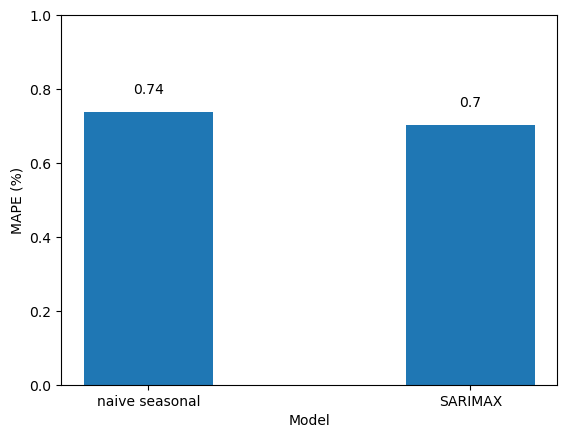

In [24]:
#find which model has the lowest MAPE   

from sklearn.metrics import mean_absolute_percentage_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

fig, ax = plt.subplots()

x= ['naive seasonal', 'SARIMAX']
y =[mape_last, mape_SARIMAX]

ax.bar(x,y, width=0.4)

ax.set_xlabel('Model')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.05, s=str(round(value,2)), ha='center')

plt.show()

> SARIMAX  is better by only 0.04% but this in terms of GDP could represent thousands or even millions dollars, which justifies SARIMAX model 